[*********************100%***********************]  1 of 1 completed


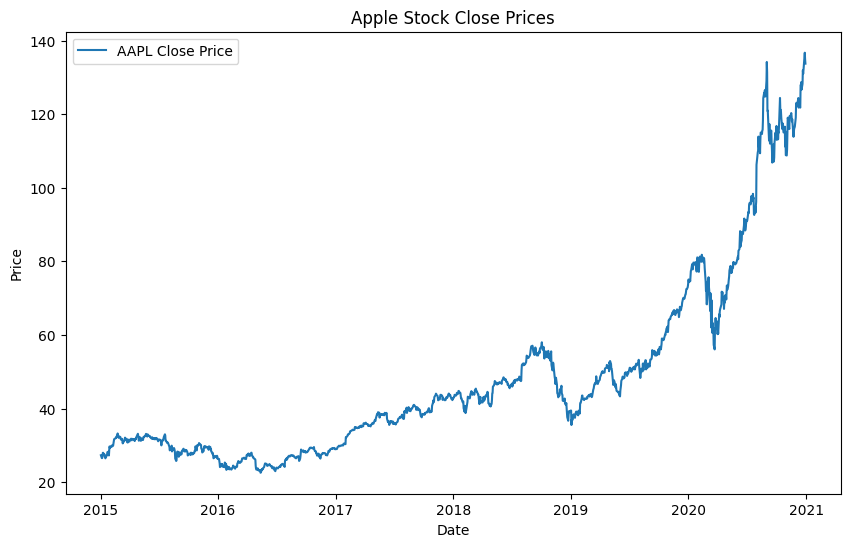

Stationarity Test on Original Data:
ADF Statistic: 2.3576310409773007
p-value: 0.9989889547510543
The series is non-stationary (p-value > 0.05).

Stationarity Test on Differenced Data:
ADF Statistic: -7.611763228566871
p-value: 2.245403397521273e-11
The series is stationary (p-value <= 0.05).


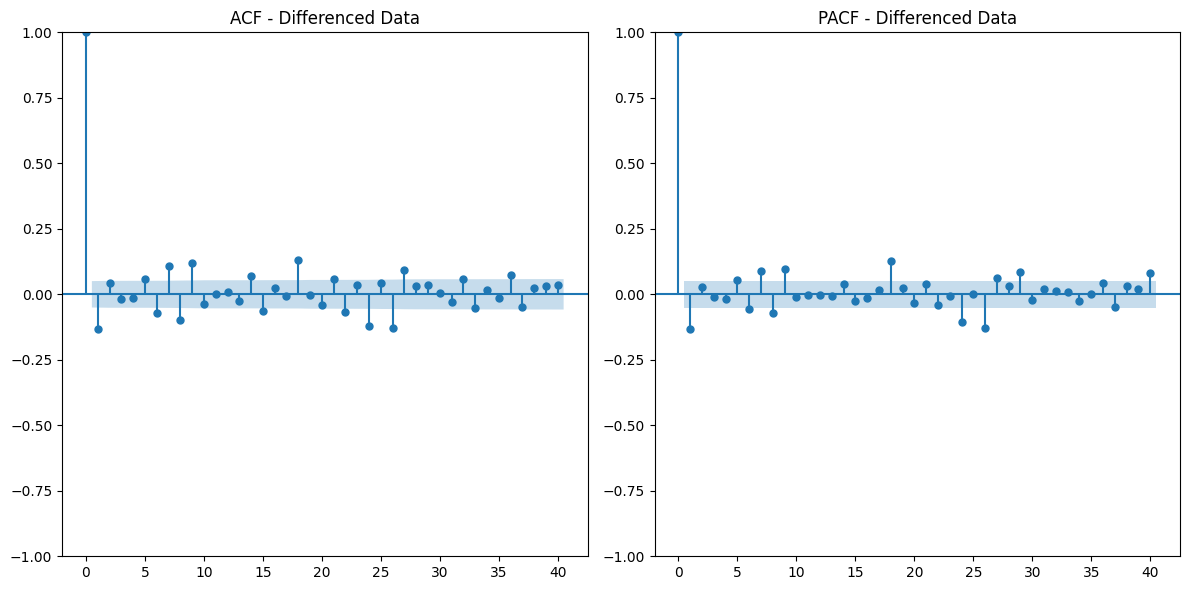

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the po


AR Model Summary:
                            AutoReg Model Results                             
Dep. Variable:                   AAPL   No. Observations:                 1509
Model:                     AutoReg(5)   Log Likelihood               -2401.601
Method:               Conditional MLE   S.D. of innovations              1.195
Date:                Sun, 03 Nov 2024   AIC                           4817.203
Time:                        23:25:47   BIC                           4854.414
Sample:                             5   HQIC                          4831.063
                                 1509                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0755      0.031      2.426      0.015       0.015       0.137
AAPL.L1       -0.1298      0.026     -5.038      0.000      -0.180      -0.079
AAPL.L2        0.0261      0.026 

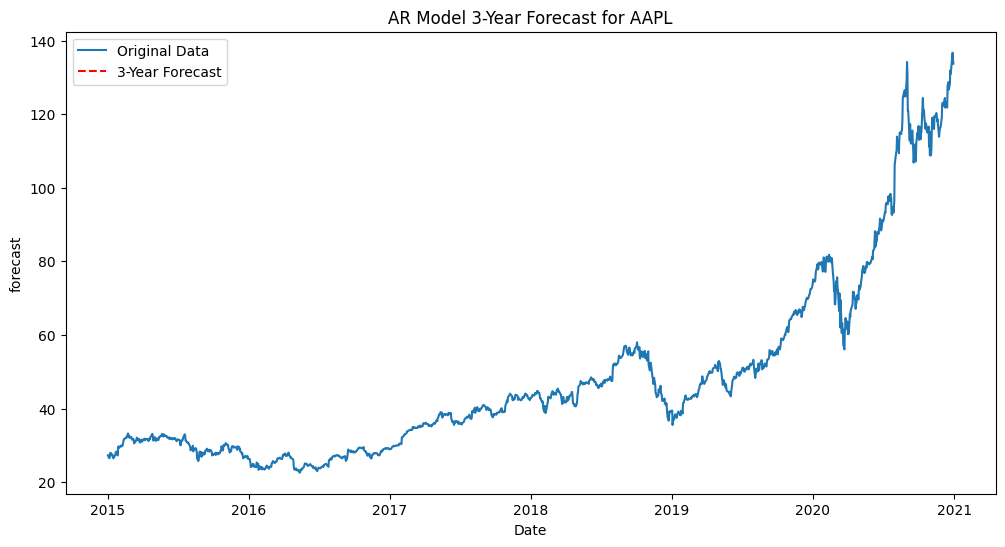

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime, timedelta

# Step 1: Load data
# Fetching data for AAPL (Apple) using Yahoo Finance from 2015-01-01 to 2020-12-31
start_date = '2015-01-01'
end_date = '2020-12-31'
stock_data = yf.download('AAPL', start=start_date, end=end_date)

# Use the 'Close' price for time series analysis
data = stock_data['Close']

# Step 2: Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(data, label='AAPL Close Price')
plt.title('Apple Stock Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 3: Check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("The series is stationary (p-value <= 0.05).")
    else:
        print("The series is non-stationary (p-value > 0.05).")

print("Stationarity Test on Original Data:")
check_stationarity(data)

# Differencing if necessary to make data stationary
data_diff = data.diff().dropna()

print("\nStationarity Test on Differenced Data:")
check_stationarity(data_diff)

# Step 3: ACF and PACF plots to determine AR order
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data_diff, lags=40, ax=plt.gca(), title="ACF - Differenced Data")
plt.subplot(122)
plot_pacf(data_diff, lags=40, ax=plt.gca(), title="PACF - Differenced Data")
plt.tight_layout()
plt.show()

# Assuming PACF shows significant correlation up to lag 5, we choose AR(5)
p = 5

# Step 4: Fit the AR model
ar_model = AutoReg(data_diff, lags=p).fit()
print("\nAR Model Summary:")
print(ar_model.summary())

# Step 5: Forecast for the next 3 years (756 trading days)
forecast_periods = 252 * 3  # 252 trading days per year
forecast_diff = ar_model.predict(start=len(data_diff), end=len(data_diff) + forecast_periods - 1, dynamic=False)

# Check if the length of forecast_diff matches forecast_periods
if len(forecast_diff) != forecast_periods:
    print(f"Warning: forecast_diff length {len(forecast_diff)} does not match forecast_periods {forecast_periods}")

# Convert differenced forecast back to original scale
forecast = data.iloc[-1] + forecast_diff.cumsum()

# Fix: Adjust the periods in pd.date_range to match the length of forecast
forecast.index = pd.date_range(start=data.index[-1] + timedelta(days=1), periods=len(forecast), freq='B')
# Step 6: Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data')
plt.plot(forecast, color='red', label='3-Year Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('forecast')
plt.title('AR Model 3-Year Forecast for AAPL')
plt.legend()
plt.show()
